# Homework 7

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 27th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

## Standard boilerplate to import torch and torch related modules
import torch

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


from torch.autograd import Variable
import torch.nn as nn

## Question 1: Mon pays c'est l'MNIST. Mon cœur est brise de Logistic Regression.

The [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database) is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves.  It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You will be using PyTorch to build a handwritten digit classifier that you will train, validate, and test with MNIST. 

Your classifier MUST implement a multinomial logistic regression model (using softmax). It will take as input an array of pixel values in an image and output the images most likely digit label (i.e. 0-9). You should think of the pixel values as features of the input vector.  

Using the softmax formulation, your PyTorch model should computes the cost function using an L2 regularization approach (see `optim.SGD` in PyTorch or write your own cost function) and minimize the resulting cost function using mini-batch stochastic gradient descent.  We provided  extensive template code in lab.

Construct and train your classifier using a batch size of 256 examples, a learning rate $\eta$=0.1, and a regularization factor $\lambda$=0.01.

1.1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).

1.2. Currently the MNIST dataset in Torchvision allows a Train/Test split.  Use PyTorch dataloader functionality to create a Train/Validate/Test split  of 50K/10K/10K samples.

**Hint:** Lab described a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`

1.3. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.

1.4. Train your model using SGD to minimize the cost function. Use as many epochs as you need to achive convergence.

1.5. Plot the cross-entropy loss on the training set as a function of iteration.

1.6. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

1.7. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for each of the different values of λ? Give an approximate answer supported by using the plots.

1.8. Select what you consider the best regularization parameter and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

1.9. What classes are most likely to be misclassified? Plot some misclassified training and test set images.

**Gratuitous Titular Reference**:  The recently departed French rockstar Johnny Hallyday just posthumously released what looks to be his biggest album ever "Mon pays c'est l'amour".  The album sold 300,000 copies on its first day of release.

In [2]:
# Regression Parent Class
class Regression(object):
    
    def __init__(self):
        self.params = dict()
    
    def get_params(self, k):
        return self.params.get(k, None)
    
    def set_params(self, **kwargs):
        for k,v in kwargs.items():
            self.params[k] = v
        
                    
    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        raise NotImplementedError()
        

In [3]:
## Our PyTorch implementation of Logistic Regression
class LRPyTorch(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 10)

    def forward(self, x):
        x = self.l1(x)
        return x

In [4]:
class MNIST_Logistic_Regression(Regression):
    
    def __init__(self, learning_rate=0.1, batch_size=256, epochs=10, reg_l2=0.01, model=LRPyTorch, hidden=None):
        super().__init__()
        train_dataset, test_dataset, train_loader, val_loader, test_loader = self.load_data(batch_size =batch_size)
        
        self.set_params(train_dataset=train_dataset, 
                        train_loader=train_loader,
                        val_loader=val_loader,
                        test_dataset=test_dataset,
                        test_loader=test_loader)
        
        
        if hidden == None:
            model = model()
        else:
            model = model(hidden)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay= reg_l2)
        self.set_params(optimizer=optimizer, 
                        learning_rate=learning_rate,
                        batch_size=batch_size,
                        model=model,
                        criterion=criterion,
                        epochs=epochs)   
        
    def load_data(self, batch_size, split = 10000):
        """load the MNIST training and test sets from MNIST"""
        train_dataset = datasets.MNIST(root='./mnist_data',
                                    train=True,
                                    transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)),
                                     ]),
                                    download=True)

        test_dataset = datasets.MNIST(root='./mnist_data',
                                   train=False,
                                   transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)),
                                     ]),
                                   download=True)

        indices = list(range(len(train_dataset)))
        validation_idx = np.random.choice(indices, size=split, replace=False)
        train_idx = list(set(indices) - set(validation_idx))
        
        train_sampler = SubsetRandomSampler(train_idx)
        validation_sampler = SubsetRandomSampler(validation_idx)

        train_loader = torch.utils.data.DataLoader(train_dataset, 
                        batch_size=batch_size, sampler=train_sampler)

        val_loader = torch.utils.data.DataLoader(train_dataset, 
                        batch_size=batch_size, sampler=validation_sampler)        
        
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                  batch_size=len(test_dataset),
                                                  shuffle=False)

        return (train_dataset, test_dataset, train_loader, val_loader, test_loader)
    
    def sample_training_images(self):
        """Create a set of sample images from the MNIST training images"""
        training_set = self.get_params('train_dataset')
        sample_indices = np.random.choice(training_set.train_data.size(0), 10)
        
        sample_images = training_set.train_data[sample_indices,:,:].numpy()
        sample_labels = [training_set.train_labels[x] for x in sample_indices]
        
        self.set_params(sample_training_images=sample_images)
        self.set_params(sample_training_labels=sample_labels)
        
    def save_misclassified(self, predictions, images, labels, sample_size = 10):
        """Create and save a set of sample images misclassified images by the model"""
        
        sample_indices = np.random.choice(range(len(predictions)), sample_size)
        
        sample_images = [np.array(images[x]).reshape(28, 28) for x in sample_indices]
        sample_labels = [predictions[x] for x in sample_indices]
        true_labels = [labels[x] for x in sample_indices]

        self.set_params(misclassified_images=sample_images)
        self.set_params(misclassified_labels=sample_labels)
        self.set_params(misclassified_true_labels=true_labels)
        
        self.set_params(all_missed_true_lables = labels)
        self.set_params(all_missed_pred = predictions)
        
        
    def viz_training_images(self):
        """Visualize/Plot sample training images"""
        
        if not self.get_params('training_labels'):
            self.sample_training_images()
        
        # get the images and labels
        sample_images = self.get_params("sample_training_images")
        sample_labels = self.get_params("sample_training_labels")
        
        fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
        plt.suptitle("Some Sample Images from MNIST", fontsize=20, weight='heavy')

        for i in range(5):
            ax1[i].imshow(sample_images[i])
            ax1[i].set_title("MNIST Label: {}".format(sample_labels[i]))
            ax2[i].imshow(sample_images[i+5])
            ax2[i].set_title("MNIST Label: {}".format(sample_labels[i+5]), weight='bold')
            
        plt.show()

    def viz_misclassified_images(self):
        """Visualize/Plot misclassified training images"""

        # get the images and labels
        sample_images = self.get_params("misclassified_images")
        sample_labels = self.get_params("misclassified_labels")
        true_labels = self.get_params("misclassified_true_labels")

        if not sample_labels:
            raise(Exception("Please run predict() or score() with save_misclassified=True"))

        fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
        plt.suptitle("Some Sample Misclassified Images", fontsize=20, weight='heavy')

        for i in range(5):
            ax1[i].imshow(sample_images[i])
            ax1[i].set_title("MNIST Label: {} Classified: {}".format(true_labels[i], sample_labels[i]), weight='bold')
            ax2[i].imshow(sample_images[i+5])
            ax2[i].set_title("MNIST Label: {} Classified: {}".format(true_labels[i+5], sample_labels[i+5]), weight='bold')

        plt.show()
        
    
    ## Stolen from excellent visualization from submission from Madeleine Duran/Sarah Walker
    def viz_training_loss(self, epochs=10):
        """Visualize/Plot our training loss"""
        
        losses = self.get_params("training_losses")
        
        if type(losses) == type(None):
            raise("Please run fit() to train data")
        
        fig, axes = plt.subplots(nrows=1, ncols=epochs, figsize=(20,5), sharex=True, sharey=True)
        
        for i in range(10):
            axes[i].plot(range(len(losses[i])), losses[i])
            axes[i].set_title("epoch {}".format(i))
            if i % 2 == 1:
                axes[i].axvspan(-10, 950, facecolor='gray', alpha=0.2)
        plt.subplots_adjust(wspace=0)
        plt.show()
    
    def get_loader(self, dataset = 'Test'):
        if dataset == 'Test':
            return self.get_params('test_loader')
        elif dataset == 'Validation':
            return self.get_params('val_loader')
        else:
            return self.get_params('train_loader')
    
    def predict(self, dataset='Test', save_misclassified=True):
        """Classify images based on the fitted logistic regression model""" 
        loader = self.get_loader(dataset)
        
        predictions = []
        true_labels = []
        misclassified_preds = []
        misclassified_images = []
        misclassified_labels = []
        
        correct = 0
        model = self.get_params('model')

        for inputs, labels in loader:
            inputs = Variable(inputs)
            inputs = inputs.view(-1, 28*28)
            outputs = model(inputs)
            pred = outputs.data.max(1)[1]
            correct += (pred == labels).sum()

            predictions += list(pred)
            true_labels += list(labels)

            if save_misclassified:
                missed = (pred != labels)
                misclassified_preds += pred[missed].tolist()
                misclassified_images += inputs[missed].tolist()
                misclassified_labels += labels[missed].tolist() #tolist()
            
        if save_misclassified:    
            self.save_misclassified(misclassified_preds, misclassified_images, misclassified_labels)
            
        self.set_params(predictions=predictions, 
                        correct_predictions=correct,
                        prediction_dataset_length=len(predictions),
                        true_labels = true_labels
                       )
        return np.array(predictions)
    
    
    def score(self, dataset='Test', print_score = False, save_misclassified=True ):
        """Calculate accuracy score based upon model classification"""
        
        self.predict(dataset=dataset, save_misclassified=save_misclassified)
        correct = self.get_params('correct_predictions')
        total = self.get_params('prediction_dataset_length')
        
        if print_score:
            print('Dataset: {} \nAccuracy: {}/{} ({:.1f}%)\n'.format(
                dataset, correct, total, 100.0 * correct / total))
        
        return(float(correct)/total)
        
        
    def fit(self, print_score = False):
        """Fit our logistic regression model on MNIST training set"""
        
        optimizer=self.get_params("optimizer")
        model=self.get_params("model")
        epochs=self.get_params("epochs")
        criterion=self.get_params("criterion")
        train_loader=self.get_params("train_loader")
        
        training_size = len(train_loader.dataset)
        iterations = int(np.ceil(training_size/self.get_params("batch_size")))
        
        losses = np.zeros((epochs, iterations)) 
        val_scores = np.zeros(epochs)
        
        for epoch in range(epochs):
            for batch_index, (inputs, labels) in enumerate(train_loader):
                inputs, labels = Variable(inputs), Variable(labels)
                inputs = inputs.view(-1, 28*28)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                losses[epoch,batch_index] = float(loss.data[0])
                loss.backward()
                optimizer.step()
        
            val_scores[epoch] = self.score(dataset = 'Validation', print_score = print_score, save_misclassified=False)
            
        self.set_params(training_losses=losses)
        self.set_params(val_scores=val_scores)
        
        return self
        

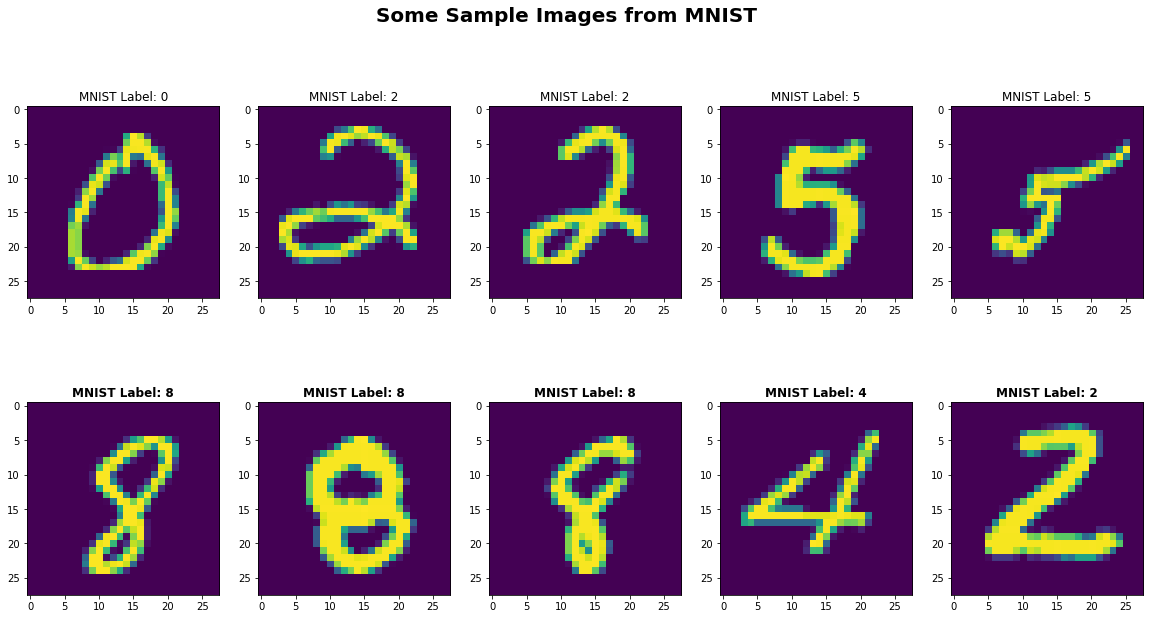

In [5]:
# 1.1
## Define our model 
MLR = MNIST_Logistic_Regression()

## Plot sample images
MLR.viz_training_images()

In [6]:
# 1.4
MLR.fit()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:238: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Text(0.5,1,'cross-entropy loss versus iteration in training set')

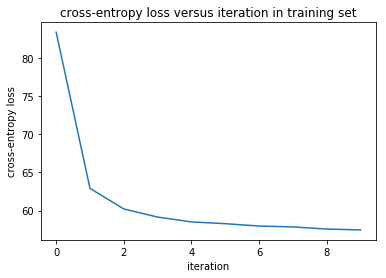

In [7]:
# 1.5
training_losses = MLR.get_params('training_losses')
plt.plot(training_losses.flatten())
plt.xlabel("iterations")
plt.ylabel("cross-entropy loss")
plt.title("cross-entropy loss versus iteration in training set")

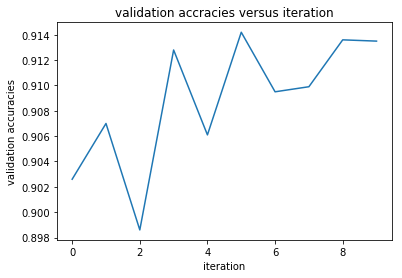

In [35]:
# 1.6
plt.plot(MLR.get_params('val_scores'))
plt.xlabel("iteration")
plt.ylabel("validation accuracies")
plt.title("validation accracies versus iteration")

/Users/gwungwun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:352: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


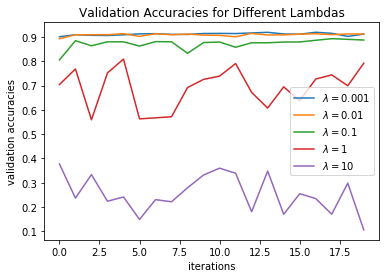

In [7]:
# 1.7
reg_ls = [0.001, 0.01, 0.1, 1, 10]
plt.title("Validation Accuracies for Different Lambdas")

for reg in reg_ls:
    MLR_tmp = MNIST_Logistic_Regression(epochs=20, reg_l2= reg)
    MLR_tmp.fit()
    plt.plot(MLR_tmp.get_params('val_losses'), label = "$\lambda = {}$".format(reg))
plt.legend()
plt.xlabel("iterations")
plt.ylabel("validation accuracies")

In [8]:
# 1.8
MLR_best = MNIST_Logistic_Regression(epochs=5, reg_l2= 0.01)
MLR_best.fit()

/Users/gwungwun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:352: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [9]:
print("classification accuracy on training set : {}" .format(MLR_best.score("Train"), save_misclassified=False))
print("classification accuracy on test set : {}" .format(MLR_best.score("Test")))

classification accuracy on training set : 0.91592
classification accuracy on test set : 0.9136


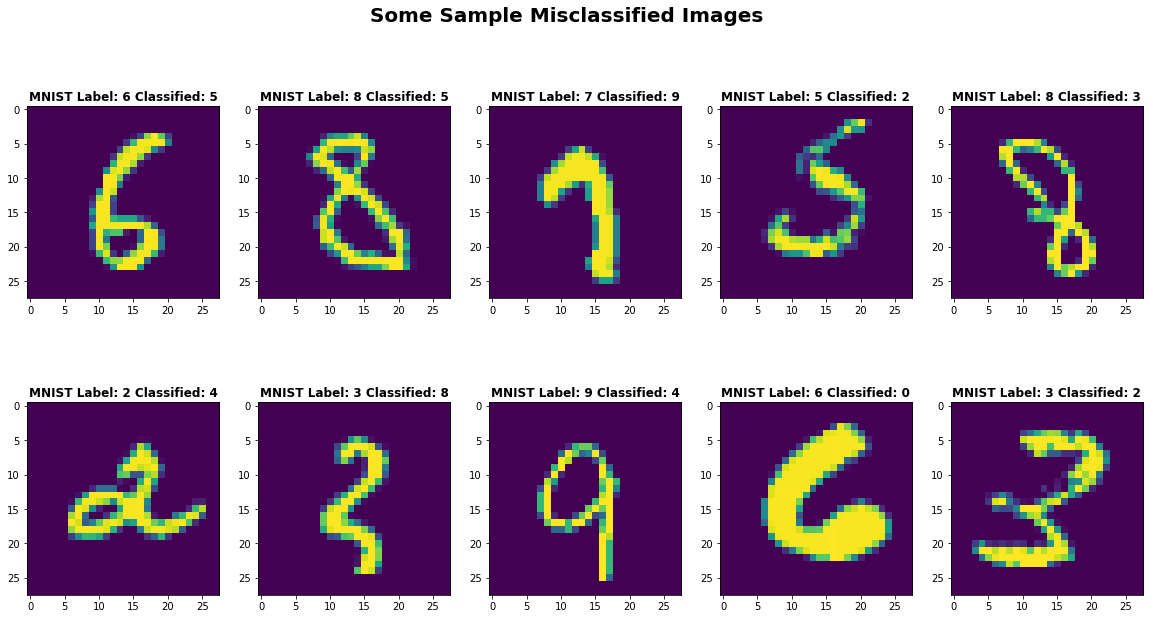

In [10]:
# 1.9
MLR_best.viz_misclassified_images()

In [11]:
true_labels = np.zeros(10)
missed_true_labels = np.zeros(10)

for l in MLR_best.get_params('true_labels'):
    true_labels[l.numpy()] +=1
for l in MLR_best.get_params('all_missed_true_lables'):
    missed_true_labels[l] += 1

for i,v in enumerate(true_labels):
    print("{}% of Labels {} are misclassified".format(100*missed_true_labels[i]/v, i))

2.0408163265306123% of Labels 0 are misclassified
2.3788546255506606% of Labels 1 are misclassified
11.046511627906977% of Labels 2 are misclassified
13.96039603960396% of Labels 3 are misclassified
4.175152749490835% of Labels 4 are misclassified
10.31390134529148% of Labels 5 are misclassified
8.872651356993737% of Labels 6 are misclassified
8.365758754863814% of Labels 7 are misclassified
11.704312114989733% of Labels 8 are misclassified
14.271555996035678% of Labels 9 are misclassified


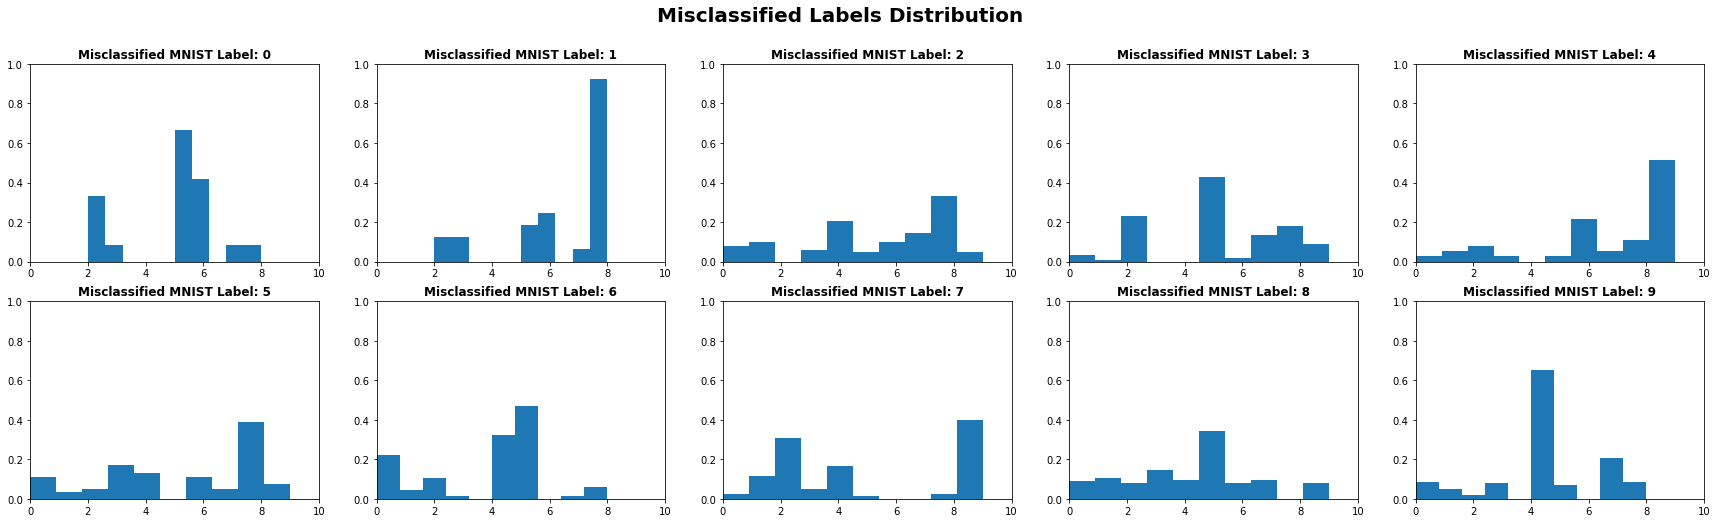

In [25]:
missed_dist = [[] for i in range(10)]
for i,v in enumerate(MLR_best.get_params('all_missed_true_lables')):
    missed_dist[int(v)].append(MLR_best.get_params('all_missed_pred')[i])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(30, 8))
plt.suptitle("Misclassified Labels Distribution", fontsize=20, weight='heavy')

for i in range(5):
    ax1[i].hist(missed_dist[i], normed = True)
    ax1[i].set_title("Misclassified MNIST Label: {}".format(i), weight='bold')
    ax1[i].set_xlim(0, 10)
    ax1[i].set_ylim(0, 1)
    ax2[i].hist(missed_dist[i + 5], normed = True)
    ax2[i].set_title("Misclassified MNIST Label: {}".format(i+5), weight='bold')
    ax2[i].set_xlim(0, 10)
    ax2[i].set_ylim(0, 1)

<div class="answer-separator">
------------------------
</div>

## Question 2: MNIST MLP!  Find out what that means to me.  MNIST MLP!  Take care, TCB!

The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is often chosen to be either the logistic function or the $\tanh$ function or the RELU function, and its purpose is to project the data into a space where it becomes linearly separable. The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. 

![](http://deeplearning.net/tutorial/_images/mlp.png)

We'll construct a model with **1 hidden layer**. That is, you will have an input layer, then a hidden layer with the nonlinearity, and finally an output layer with cross-entropy loss (or equivalently log-softmax activation with a negative log likelihood loss).

2.1. Using a similar architecture as in Question 1 and the same training, validation and test sets, build a PyTorch model for the multilayer perceptron. Use the $\tanh$ function as the non-linear activation function. 

2.2. The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, you may find it advisable to initialize with the interval $\left[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}\right]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.  This is known as **Xavier Initialization**.  Use Xavier Initialization to initialize your MLP.  Feel free to use PyTorch's in-built Xavier Initialization methods.

2.3. Using $\lambda = 0.01$ to compare with Question 1, experiment with the learning rate (try 0.1 and 0.01 for example), batch size (use 64, 128 and 256) and the number of units in your hidden layer (use between 25 and 200 units). For what combination of these parameters do you obtain the highest validation accuracy?  You may want to start with 20 epochs for running time and experiment a bit to make sure that your models reach convergence. 

2.4. For your best combination plot the cross-entropy loss on the training set as a function of iteration.

2.5. For your best combination use classification accuracy to evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains.

2.6. Select what you consider the best set of parameters and predict the labels of the test set. Compare your predictions with the given labels. What classification accuracy do you obtain on the training and test sets?

2.7. How does your test accuracy compare to that of the logistic regression classifier in Question 1?  Compare best parameters for both models.

2.8. What classes are most likely to be misclassified? Plot some misclassified training and test set images.


**Gratuitous Titular Reference**:  Respect, originally performed by Otis Redding, became a huge hit and an anthem for the recently departed "Queen of Soul" Aretha Franklin.  Respect is often credited with popularizing the word usages "propers" (a synonym for respect) and "sock it to me".

In [26]:
# 2.1
class MLPTorch(nn.Module):

    ## the constructor is where we'll define all our layers (input, hidden, and output)
    def __init__(self, hidden = 25):

        ## this line creates an instance of our parent (or base) class which in this case
        ## is nn.Module.
        super().__init__()

        ## in the lines below we'll create instance variables and assign them torch.nn Models
        ## in order to create our layers.  You should ordinarily have one variable definition for each layer
        ## in your neural network except for the output layer.  The output layer is defined by the number of
        ## outputs in your last layer. Since we're dealing with simple Artificial Neural Networks, we should
        ## predominantly be using nn.Linear.  
        self.l1 = nn.Linear(784, hidden)
        torch.nn.init.xavier_uniform(self.l1.weight)
        
        self.l2 = nn.Linear(hidden, 10)

 
    # forwards takes as a parameter x -- the batch of inputs that we want to feed into our neural network model
    # and returns the output of the model ... i.e. the results of the output layer of the model after forward
    # propagation through our model. practically this means you should call each layer you defined in the
    # constructor in sequence plus any activation functions on each layer.
    def forward(self, x):
     
        # call all our layers on our input (in this case we only need one)
        x = self.l1(x)
        x = torch.tanh(x)
        x = self.l2(x)

        # Since we're using Cross Entropy Loss
        # we can return our output directly
        return x

In [ ]:
# 2.3

lr_ls =  [0.1, 0.01]
batch_size_ls = [64, 128, 256] 
hidden_ls = [25, 200] 
result_ls = []

for lr in lr_ls:
    for batch_size in batch_size_ls:
        for hidden in hidden_ls:
            MLP = MNIST_Logistic_Regression(learning_rate = lr, reg_l2=0.01, batch_size= batch_size, hidden = hidden, model= MLPTorch, epochs=25)
            MLP.fit()
            plt.plot(MLP.get_params('val_losses'), label = "learning rate = {}, batch size = {}, hidden nodes = {}".format(lr, batch_size, hidden))
            result_ls.append(MLP.get_params('val_losses'))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("iterations")
plt.ylabel("validation accuracies")

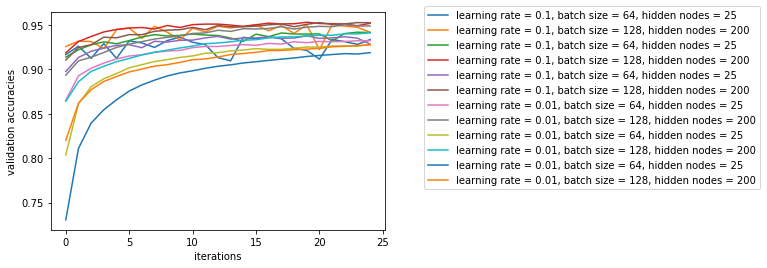

In [35]:
for i, v in enumerate(result_ls):
    plt.plot(v, label = "learning rate = {}, batch size = {}, hidden nodes = {}".format(lr_ls[i//6], batch_size_ls[(i - i//6*6)%2], hidden_ls[i%2]))
            
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("iterations")
plt.ylabel("validation accuracies")

/Users/gwungwun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/Users/gwungwun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:352: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


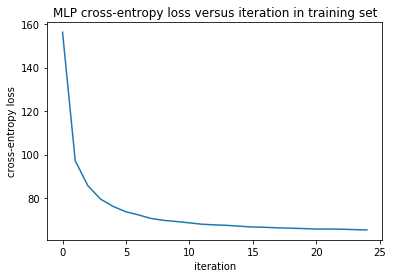

In [36]:
# 2.4
MLP = MNIST_Logistic_Regression(learning_rate = 0.1, reg_l2=0.01, batch_size= 128, hidden = 200, model= MLPTorch, epochs=25)
MLP.fit()
plt.plot(MLP.get_params('training_losses').sum(axis = 1))
plt.xlabel("iteration")
plt.ylabel("cross-entropy loss")
plt.title("MLP cross-entropy loss versus iteration in training set")

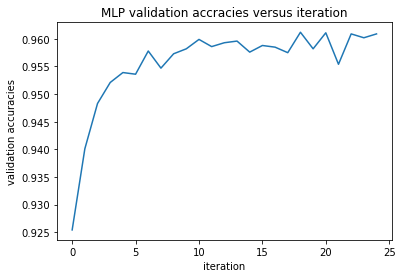

In [37]:
# 2.5
plt.plot(MLP.get_params('val_losses'))
plt.xlabel("iteration")
plt.ylabel("validation accuracies")
plt.title("MLP validation accracies versus iteration")

In [38]:
# 2.6
print("MLP classification accuracy on training set : {}" .format(MLP.score("Train"), save_misclassified=False))
print("MLP classification accuracy on test set : {}" .format(MLP.score("Test")))

MLP classification accuracy on training set : 0.96016
MLP classification accuracy on test set : 0.959


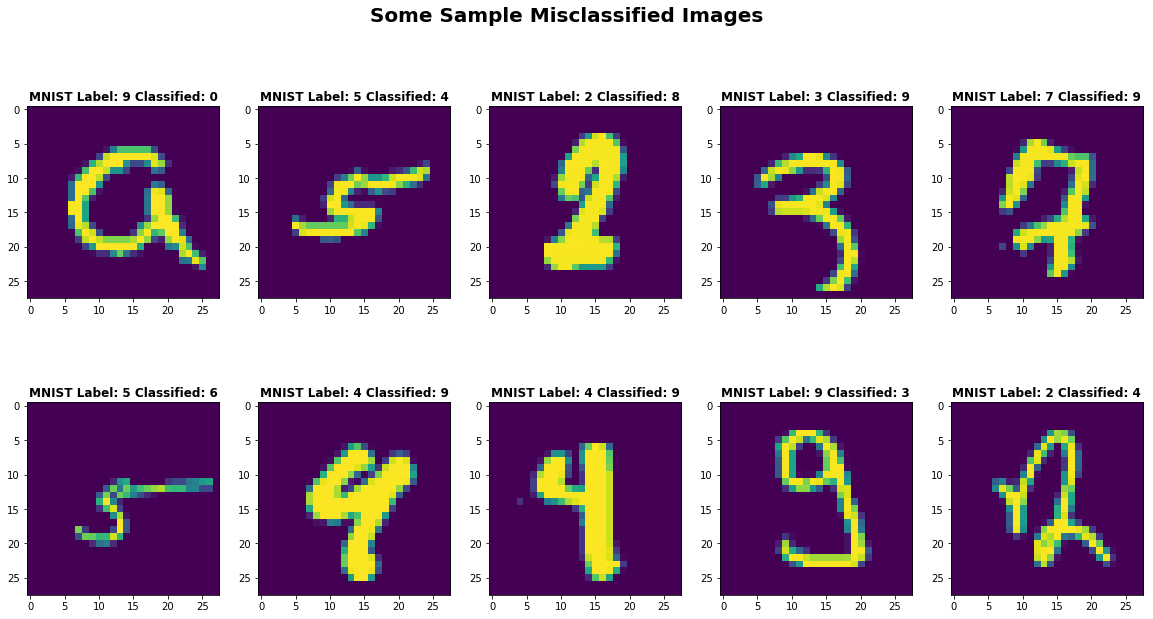

In [39]:
# 2.8
MLP.viz_misclassified_images()

In [40]:
true_labels = np.zeros(10)
missed_true_labels = np.zeros(10)

for l in MLP.get_params('true_labels'):
    true_labels[l.numpy()] +=1
for l in MLP.get_params('all_missed_true_lables'):
    missed_true_labels[l] += 1

for i,v in enumerate(true_labels):
    print("{}% of Labels {} are misclassified".format(100*missed_true_labels[i]/v, i))

1.1224489795918366% of Labels 0 are misclassified
1.7621145374449338% of Labels 1 are misclassified
4.069767441860465% of Labels 2 are misclassified
4.9504950495049505% of Labels 3 are misclassified
4.684317718940937% of Labels 4 are misclassified
4.932735426008969% of Labels 5 are misclassified
4.07098121085595% of Labels 6 are misclassified
5.544747081712062% of Labels 7 are misclassified
3.696098562628337% of Labels 8 are misclassified
6.442021803766105% of Labels 9 are misclassified


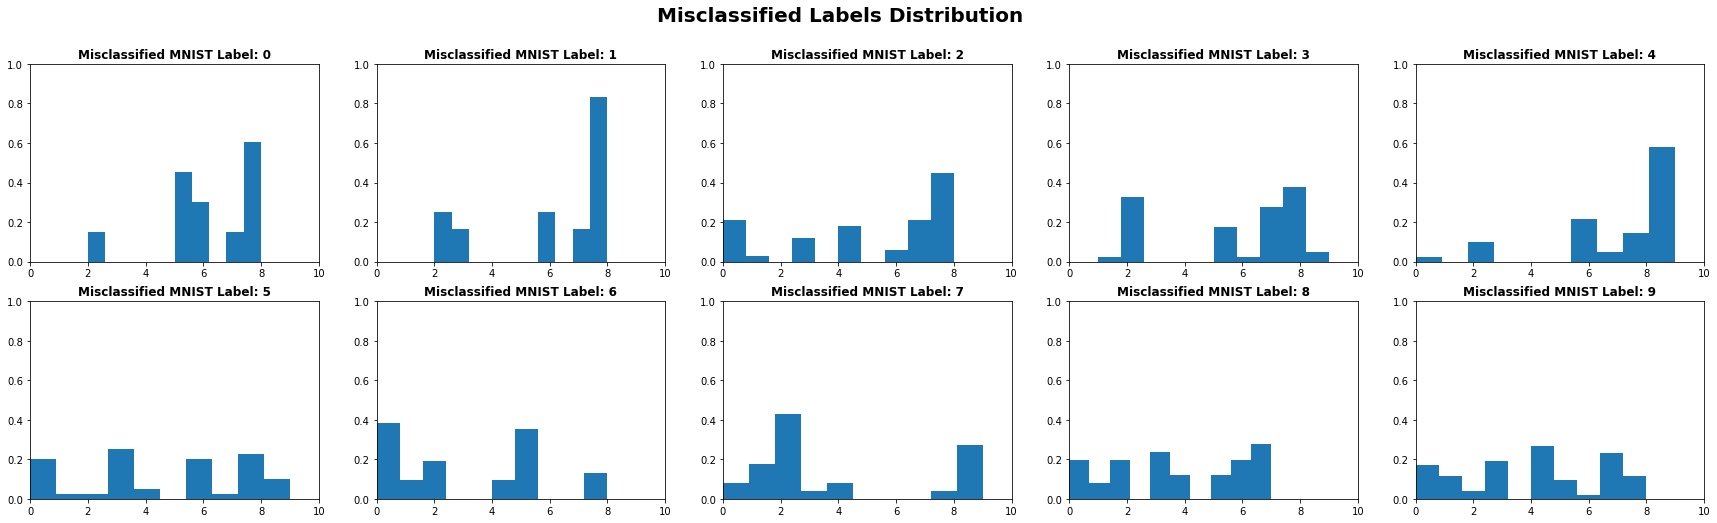

In [41]:
missed_dist = [[] for i in range(10)]
for i,v in enumerate(MLP.get_params('all_missed_true_lables')):
    missed_dist[int(v)].append(MLP.get_params('all_missed_pred')[i])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(30, 8))
plt.suptitle("Misclassified Labels Distribution", fontsize=20, weight='heavy')

for i in range(5):
    ax1[i].hist(missed_dist[i], normed = True)
    ax1[i].set_title("Misclassified MNIST Label: {}".format(i), weight='bold')
    ax1[i].set_xlim(0, 10)
    ax1[i].set_ylim(0, 1)
    ax2[i].hist(missed_dist[i + 5], normed = True)
    ax2[i].set_title("Misclassified MNIST Label: {}".format(i+5), weight='bold')
    ax2[i].set_xlim(0, 10)
    ax2[i].set_ylim(0, 1)

<div class="answer-separator">
------------------------
</div>